# Costa Rica Pipeline Notebook

This is the `Data Acquisition / Cleaning` section of the notebook where:

- SP and EN GeoDataFrames from `"Costa_Rica_Data/Setup Output"` are imported
- Creation of a generic single point-per-plot GeoDataFrame with statistical columns on %forest, %agriculture, %every other Uso class, etc. per plot (**`TODO`**)
- An Exploratory Data Analysis (using `gdf_s or gdf_e`) focused on:
    1. Analyzing plots and points, identifying their NA values, and detecting/removing duplicate entries
    2. Visualizations for showing %UseType cover (**`TODO`**)
    3. Calculation of descriptive statistics for %UseType (i.e. `min, max, mean, std dev, std err, confidence interval`) using the single point-per-plot GeoDataFrame (**`TODO`**)
    4. Replacing NA values in columsn with `"Not_Applicable"` (`TOOD`)
- Acquisition of data from Google Earth Engine (`predictor values`)
- An EDA using the `acquired/transformed data` from GEE focused on:
    1. Dealing with NA values
- Data Reduction Techniques are implemented on our `transformed data` (e.g. `PCA, CCA, factor analysis, etc.`) (**`TODO`**)

## Section 1 - Setup

### Section 1.1 - Installing software and importing packages

In [113]:
!pip install pandas numpy geopandas seaborn scikit-learn tensor folium matplotlib mapclassify earthengine-api geemap pyarrow


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [114]:
from IPython.core.display import display_webp
from geopandas import GeoDataFrame
from shapely.geometry import Point
import geopandas as gpd
import pandas as pd
import numpy as np
import geemap
import ee
import folium
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow

### Section 1.2 - Importing our Dataset

In [115]:
# We are importing the observational data from the ZIP file provided (which contains the shape file) into a GeoDataFrame
gdf_s = gpd.read_parquet('../Costa_Rica_Data/Setup Output/sp_setup_data.parquet')
gdf_e = gpd.read_parquet('../Costa_Rica_Data/Setup Output/en_setup_data.parquet')

# These display information about the GeoDataFrame to confirm the contains are what we expected
display(gdf_s.columns)
display(gdf_e.columns)

# Confirming that these are GeoDataFrames
display(type(gdf_s))
display(type(gdf_e))

Index(['plotid', 'sampleid', 'Uso', 'Cobertura', 'Vegetacion', 'Herbaceas',
       'Pasto_Arb', 'Cultivo', 'Humedal', 'Terreno', 'Agua', 'Otra_clase',
       'SAF', 'Cambios15_', 'Gana_Perdi', 'geometry'],
      dtype='object')

Index(['plotid', 'sampleid', 'Use', 'CoverType', 'Vegetations', 'Herbaceous',
       'GrasslandShrub', 'CropsType', 'WetlandArea', 'LandType',
       'WaterBodyType', 'OtherClass', 'SAF', 'Changes_15', 'Gain_Loss',
       'geometry'],
      dtype='object')

geopandas.geodataframe.GeoDataFrame

geopandas.geodataframe.GeoDataFrame

## Section 2 - Data Acquisition and Cleaning

### Section 2.1 - Points imported, and points turned into "wide" format for the "9->1 row per plot conversion

In [116]:
# Insert code here for Section 2.1

### Section 2.2 - Exploratory Data Analysis (EDA)

#### Section 2.2.1 Exploration of Plots and Points

In [117]:
# Count of points, count of plots, and ID of NA's (if appropriate).

# Reworked solution - Convert columns to objects and get those statistics instead of the numerical ones
plotid_obj_stats = (gdf_s['plotid'].astype('object')).describe()
sampleid_obj_stats = (gdf_s['sampleid'].astype('object')).describe()

# Combine above results into a single dataframe
results_df = pd.concat([plotid_obj_stats, sampleid_obj_stats], axis=1)

# Check for NAs in each column and append to dataframe
results_df.loc["Has NAs"] = [str(gdf_s['plotid'].isna().any()), str(gdf_s['sampleid'].isna().any())]

# Display results
display(results_df)

plotid sampleid
count    101160   101160
unique    11233    49469
top        2175    12417
freq         18        4
Has NAs   False    False

In summary, out of the **101,160 rows of data** in our Dataframe, there are only:
- 11,233 unique plots,
- 49,469 unique sampleids (points).

However, you can notice that the highest frequency for sampleids is more than 1, which means there are sampleids being used more than once.

> Question 1: How many sampleids (points) are being used more than one time?

Also, there are no NA values in these two columns.

In [118]:
# Count of plots that have fewer than 9 points per plot (and why)

# Create subsets of gdf_s where the frequency of the plotid/sampleid is calculated
plotid_counts = pd.DataFrame(gdf_s['plotid'].value_counts(dropna=False))
sampleid_counts = pd.DataFrame(gdf_s['sampleid'].value_counts(dropna=False))

# Creates subsets of sampleid_counts that counts the frequency of each points' frequency
sampleid_counts_mt0 = sampleid_counts[sampleid_counts['count'] > 0]
sampleid_counts_frequency = pd.DataFrame(sampleid_counts_mt0['count'].value_counts())
sampleid_counts_frequency.rename(columns={ sampleid_counts_frequency.columns[0]: "count frequency" }, inplace=True)

print("There are {number_of_rows} plotid's with less than 9 points per plot:".format(number_of_rows=len(plotid_counts[plotid_counts['count'] < 9])))
display(plotid_counts[plotid_counts['count'] < 9])

print("There are {number_of_rows} plotid's with more than 9 points per plot:".format(number_of_rows=len(plotid_counts[plotid_counts['count'] > 9])))
display(plotid_counts[plotid_counts['count'] > 9])

# This answers Question 1: "How many sampleids (points) are being used more than one time?"
print("There are {number_of_rows} points that appear more than once:".format(number_of_rows=len(sampleid_counts[sampleid_counts['count'] > 1])))
display(sampleid_counts_frequency)

There are 0 plotid's with less than 9 points per plot:


Empty DataFrame
Columns: [count]
Index: []

There are 7 plotid's with more than 9 points per plot:


count
plotid       
2175       18
4607       18
6916       18
3150       18
3105       18
3163       18
1630       18

There are 41437 points that appear more than once:


count frequency
count                 
2                31204
3                10212
1                 8032
4                   21

In summary, out of all the unique plots in our data:
- **None** have less than nine points per plot
- **Seven** have more than nine points per plot (exactly 18 in fact)

> Question 2: Why do those seven plots have 18 points instead of nine?

> Question 3: Are all 18 of those points unique, or are some of them repeated?

##### **Recall Question 1: "How many sampleids (points) are being used more than one time?"**

Out of all the sampleids (points) in our data:
- **21** appear four times
- **10,212** three times
- **31,204** appear two times
- **8,032** appear one time

> Question 4: Are there sampleids that are associated with **more than one** unique geometric point?

In [119]:
# This answers Question 2: "Why do those seven plots have 18 points instead of nine?"
# Also Question 3: "Are all 18 of those points unique, or are some of them repeated?"

"""
This function groups a DataFrame by `id_name`, checks if the `associated_id` values in each group are unique, and returns:
1) A DataFrame with all groups and their uniqueness status.
2) A filtered DataFrame showing only groups with duplicate `associated_id` values.
"""
def analyze_ids(df, id_name, associated_id):
    # Filter 'sampleid' values where 'geometry' equals a specific value
    result = df.groupby(id_name)[associated_id].apply(list)

    # Create a new DataFrame from the result
    result_df = result.reset_index(name=(associated_id + "_list"))

    # Add a column to check if all sampleid values are unique
    result_df['all_unique'] = result_df[associated_id + "_list"].apply(lambda x: len(x) == len(set(x)))

    # Filter rows where all_unique == False
    duplicated_rows = result_df[result_df['all_unique'] == False].copy()

    # Adjust the sampleid_list column to show only duplicated values
    duplicated_rows['duplicated_' + associated_id] = duplicated_rows[associated_id + "_list"].apply(
        lambda x: [item for item in set(x) if x.count(item) > 1]
    )

    return result_df, duplicated_rows[[id_name, 'duplicated_' + associated_id]]

# Use the defined function above to check which sampleids are associated with which plotid
results_df, duplicates_df = analyze_ids(gdf_s, "plotid", "sampleid")

# Display the results
display(results_df[results_df['all_unique'] == False])
display(duplicates_df)

plotid                                      sampleid_list  all_unique
1610    1630  [6517, 6517, 6518, 6518, 6519, 6519, 6520, 652...       False
2153    2175  [8697, 8697, 8698, 8698, 8699, 8699, 8700, 870...       False
3082    3105  [12417, 12417, 12418, 12418, 12419, 12419, 124...       False
3127    3150  [12597, 12597, 12598, 12598, 12599, 12599, 126...       False
3140    3163  [12649, 12649, 12650, 12650, 12651, 12651, 126...       False
4584    4607  [18425, 18425, 18426, 18426, 18427, 18427, 184...       False
6893    6916  [27661, 27661, 27662, 27662, 27663, 27663, 276...       False

plotid                                duplicated_sampleid
1610    1630  [6517, 6518, 6519, 6520, 6521, 6522, 6523, 652...
2153    2175  [8704, 8705, 8697, 8698, 8699, 8700, 8701, 870...
3082    3105  [12417, 12418, 12419, 12420, 12421, 12422, 124...
3127    3150  [12597, 12598, 12599, 12600, 12601, 12602, 126...
3140    3163  [12649, 12650, 12651, 12652, 12653, 12654, 126...
4584    4607  [18432, 18433, 18425, 18426, 18427, 18428, 184...
6893    6916  [27661, 27662, 27663, 27664, 27665, 27666, 276...

##### **Recall Questions 2 & 3: "Why do those seven plots have 18 points instead of nine; also, are all 18 of those points unique, or are some of them repeated?"**
Visually, we can tell that these seven plots:
- Have had 9 sampleid's counted twice,
- Do not have all associated sampleid's unique.

> Question TODO: In those seven plotids with 18 sampleids, do the duplicated sampleids contain the same information?

In [120]:
# This answers Question 4: "Are there sampleids that are associated with more than one unique geometric point?"

# Call the analyze_ids function to analyze the values of each sampleid and determine if and what the duplicates are
results_df, duplicates_df = analyze_ids(gdf_s, "sampleid", "geometry")

results_mt1_geopoint = results_df[results_df['geometry_list'].apply(len) > 1]

# Display the results of the above function call
display(results_mt1_geopoint[results_mt1_geopoint['all_unique'] == True].head())
display(results_df.shape)
display(results_mt1_geopoint[results_mt1_geopoint['all_unique'] == True].shape[0])
display(results_df[results_df['all_unique'] == False].shape[0])

sampleid                                      geometry_list  all_unique
4         9  [POINT (-85.132333 9.614592000000002), POINT (...        True
5        10  [POINT (-85.132333 9.615017134355497), POINT (...        True
6        11  [POINT (-85.13190180866356 9.614166865110107),...        True
7        12  [POINT (-85.13190180866356 9.614592000000002),...        True
8        13  [POINT (-85.13190180866356 9.615017134355497),...        True

(49469, 3)

41374

63

**Recall Question 4: "Are there sampleids that are associated with **more than one** unique geometric point?"**

To answer this, we're going to analyze the `geometric` column, in the `gdf_s` dataframe, for each `sampleid` that appears **more than once**.

> Note: We are using the `geometric` column since it aggregates the longitude and latitude into a single column and data type

Taking a look at the resulting dataframe from our analysis function, we can tell that from the 49,469 unique sampleids:
- 41,374 are associated with **multiple unique** geometric points
- 63 are associated with **some duplicated** geometric points

Therefore, the answer to Question 4 is **Yes**, since 41,374 sampleids are associated with **more than one** unique geometric point.

> Question 5: Are there geometry points that are associated with **more than one** unique sampleid?

In [121]:
# This should answer Question 5: "Are there geometry points that are associated with more than one unique sampleid?"

results_df, duplicates_df = analyze_ids(gdf_s, "geometry", "sampleid")

results_mt1_sampleid = results_df[results_df['sampleid_list'].apply(len) > 1]

# Uncomment to show that there are no geometry points associated with more than two sampleids
#display(results_df[results_df['sampleid_list'].apply(len) > 2])

# Display the results of the above function call
display(results_mt1_sampleid[results_mt1_sampleid['all_unique'] == True].head())
display(results_df.shape)
display(results_mt1_sampleid[results_mt1_sampleid['all_unique'] == True].shape[0])
display(results_df[results_df['all_unique'] == False].shape[0])

geometry   sampleid_list  all_unique
36  POINT (-84.37434 9.50804)  [227, 3600227]        True
37   POINT (-84.3739 9.50804)  [230, 3600230]        True
38   POINT (-84.3739 9.50762)  [229, 3600229]        True
39  POINT (-84.37434 9.50762)  [226, 3600226]        True
40  POINT (-84.37434 9.50719)  [225, 3600225]        True

(91917, 3)

9180

63

**Recall Question 5: "Are there geometry points that are associated with more than one unique sampleid?"**

With the analysis function used previous, we can aggregate all the sampleids associated with each geometry point.

Taking a look at the resulting table, and its dimensions, we can see that of the 91,917 unique geometry points:
- 9,180 are associated with multiple **unique** sampleids
- 63 are associated with multiple **of the same** sampleids

> Note: We know this because each geometry point is only associated with **up to** two sampleids (shown by the commented code above)

In [122]:
# Figure out which rows are associated with QA/QC entries
# To do that, let's take a look at the plotids and sampleids of the duplicated geometric points

duplicated_sampleids = results_mt1_sampleid[results_mt1_sampleid['all_unique'] == True]

results_df, duplicates_df = analyze_ids(gdf_s, "geometry", "plotid")
results_mt1_plotid = results_df[results_df['plotid_list'].apply(len) > 1]
duplicated_plotids = results_mt1_plotid[results_mt1_plotid['all_unique'] == True]

# Uncomment to show that both dataframes contains the same geometric points (values in the geometry column)
#display(duplicated_sampleids['geometry'].equals(duplicated_plotids['geometry']))

qaqc_df = pd.merge(duplicated_plotids, duplicated_sampleids, how='inner', on='geometry')
qaqc_df = qaqc_df.drop(columns=['all_unique_x', 'all_unique_y'])

display(qaqc_df.head(10))
display(qaqc_df['geometry'].value_counts().reset_index()['count'].unique())
display(qaqc_df['plotid_list'].explode().value_counts().reset_index()['count'].unique())
display(qaqc_df['sampleid_list'].explode().value_counts().reset_index()['count'].unique())

geometry      plotid_list     sampleid_list
0  POINT (-84.37434 9.50804)     [57, 900057]    [227, 3600227]
1   POINT (-84.3739 9.50804)     [57, 900057]    [230, 3600230]
2   POINT (-84.3739 9.50762)     [57, 900057]    [229, 3600229]
3  POINT (-84.37434 9.50762)     [57, 900057]    [226, 3600226]
4  POINT (-84.37434 9.50719)     [57, 900057]    [225, 3600225]
5   POINT (-84.3739 9.50719)     [57, 900057]    [228, 3600228]
6  POINT (-84.37347 9.50719)     [57, 900057]    [231, 3600231]
7  POINT (-84.37347 9.50762)     [57, 900057]    [232, 3600232]
8  POINT (-84.37347 9.50804)     [57, 900057]    [233, 3600233]
9  POINT (-84.26062 9.50729)  [10231, 910231]  [40921, 3640921]

array([1])

array([9])

array([3, 2, 1])

---
Looking at the dataframe displayed, we can see all the plotids and sampleids associated with each geometric point.
> Note: As a reminder the geometric points in this dataframe are the ones that appear more than once (exactly twice) in the dataset

Empirically, we can observe that in this dataframe it seems all QA/QC entries, (NOTE), have a pattern of adding a certain amount to get the new id.
> Note: (that are not assigned the same sampleid),
- For example, 900,000 is added to the original plotid to get the new QA/QC plotid.
- In case of sampleids, it seems 3,600,000 is added.

Once we have fact-checked our empirical observation, in the next cell, we can go ahead and determine which entries to keep and which to remove.

---

The next three lines describe the frequency of each unique value in the given column, so:
- There is 1 occurance of each geometric point (as expected),
- There are 9 occurances of each plotid (as expected),
- There are 1, 2, or 3 occurances of each sampleid (**not expected**).

Based on this, it demonstrates that a lot of geometric points are being associated with sampleids used by different geometric points.
> Thought: It might be best if we went through the dataset and assigned each geometric point a unique sampleid

In [123]:
# TODO: Use the actual 10,000 row dataset instead of this makeshift version
# Map the plots (the 10,000 not the 90,000)

# Create a makeshift subset of the original GeoDataFrame
downsampled_gdf = gdf_s.iloc[::9]

# Calculate the mean geometric point to center the map
mean_point = downsampled_gdf.geometry.union_all().centroid
mean_lat, mean_lon = mean_point.y, mean_point.x

# Initialize a Folium map centered on the mean geometric point
m = folium.Map(location=[mean_lat, mean_lon], zoom_start=9)

# Add each point from the downsampled GeoDataFrame to the map
for _, row in downsampled_gdf.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=1,  # Smaller radius for points
        color="blue",
        fill=True,
        fill_color="blue",
        fill_opacity=0.7
    ).add_to(m)

# Display the map
display(m)

Using folium, and a makeshift subset of our original dataset, this creates a map of one point per plot.

### Section 2.3 - Acquisition of data from GEE

#### Section 2.3.1 - Extraction of predictor values with GEE/Planetary Computer code to extract the pixel values under plots

In [124]:
# The output of John's Code (English version)
gdf_predictors = gpd.read_parquet(
    '../Costa_Rica_Data/Data Acquisition Output/extracted_gee_data/en_basic_gee_data.parquet')
# Confirming the columns of the GeoDataFrame and it's type
display(gdf_predictors.columns)
display(type(gdf_predictors))

Index(['plotid', 'sampleid', 'Use', 'CoverType', 'Vegetations', 'Herbaceous',
       'GrasslandShrub', 'CropsType', 'WetlandArea', 'LandType',
       'WaterBodyType', 'OtherClass', 'SAF', 'Changes_15', 'Gain_Loss',
       'geometry', 'BLUE', 'GREEN', 'NIR', 'RED', 'SWIR1', 'SWIR2', 'altura2',
       'aspect', 'aspectcos', 'aspectdeg', 'aspectsin', 'brightness',
       'clay_1mMed', 'diff', 'elevation', 'evi', 'fpar', 'hand30_100', 'lai',
       'mTPI', 'ndvi', 'ocs_1mMed', 'sand_1mMed', 'savi', 'silt_1mMed',
       'slope', 'topDiv', 'wetness'],
      dtype='object')

geopandas.geodataframe.GeoDataFrame

#### Section 2.3.2 - EDA on this dataset of predictors

In [125]:
# Columns to replace NA values
columns_to_replace = ['plotid', 'sampleid', 'Use', 'CoverType', 'Vegetations', 'Herbaceous', 'GrasslandShrub', 'CropsType', 'WetlandArea', 'LandType', 'WaterBodyType', 'OtherClass', 'SAF', 'Changes_15', 'Gain_Loss', 'geometry']

# Replace NA values with "Not_Applicable"
gdf_predictors[columns_to_replace] = gdf_predictors[columns_to_replace].fillna("Not_Applicable")

# Prints the NA count for column with NA values
na_count = gdf_predictors.isna().sum()
print(na_count[na_count > 0])

BLUE            30
GREEN           26
NIR             26
RED             26
SWIR1           26
SWIR2           26
altura2       3979
brightness      26
diff            26
evi             30
hand30_100       3
mTPI           178
ndvi           368
savi            26
topDiv         178
wetness         26
dtype: int64


Based on our understanding of the dataset, the classification columns contained NA values.

Therefore, using the `fillna` function, we replace all of those with "Not_Applicable".

---

One other thing we notice, is the predictor columns (i.e. BLUE -> wetness) all contain some level of NA values.

Therefore, we should find a way to replace those too.

In [126]:
# Filling all the numeric values that are missing with the mean from the column
columns_to_fill = ['BLUE', 'GREEN', 'NIR', 'RED', 'SWIR1', 'SWIR2', 'altura2', 'brightness', 'diff', 'evi', 'hand30_100','mTPI', 'ndvi', 'savi', 'topDiv','wetness']  # Specify the columns to fill
for column in columns_to_fill:
    gdf_predictors[column] = gdf_predictors[column].fillna(gdf_predictors[column].mean())

In [127]:
#print(gdf.dtypes)
na_count = gdf_predictors.isna().sum()
print(na_count)

plotid            0
sampleid          0
Use               0
CoverType         0
Vegetations       0
Herbaceous        0
GrasslandShrub    0
CropsType         0
WetlandArea       0
LandType          0
WaterBodyType     0
OtherClass        0
SAF               0
Changes_15        0
Gain_Loss         0
geometry          0
BLUE              0
GREEN             0
NIR               0
RED               0
SWIR1             0
SWIR2             0
altura2           0
aspect            0
aspectcos         0
aspectdeg         0
aspectsin         0
brightness        0
clay_1mMed        0
diff              0
elevation         0
evi               0
fpar              0
hand30_100        0
lai               0
mTPI              0
ndvi              0
ocs_1mMed         0
sand_1mMed        0
savi              0
silt_1mMed        0
slope             0
topDiv            0
wetness           0
dtype: int64


After replacing the NA values with the mean of the column, we are left with a dataset that has no NA values.

In [128]:
display(gdf_predictors.head(10))
display(gdf_predictors['Use'].unique())
display(gdf_predictors['CoverType'].unique())

plotid  sampleid         Use   CoverType        Vegetations  \
0    2900     11597      Forest  Vegetation              Trees   
1    2900     11598  Grasslands  Vegetation  Herbaceous plants   
2    2900     11599  Grasslands  Vegetation  Herbaceous plants   
3    2900     11600      Forest  Vegetation              Trees   
4    2900     11601      Forest  Vegetation              Trees   
5    2900     11602      Forest  Vegetation              Trees   
6    2900     11603      Forest  Vegetation              Trees   
7    2900     11604      Forest  Vegetation              Trees   
8    2900     11605      Forest  Vegetation              Trees   
9    2902     11605    Wetlands  Vegetation              Trees   

       Herbaceous          GrasslandShrub       CropsType     WetlandArea  \
0  Not_Applicable          Not_Applicable  Not_Applicable  Not_Applicable   
1         Grasses  Mixed Pasture (70-90%)  Not_Applicable  Not_Applicable   
2         Grasses  Mixed Pasture (70-90%)  Not_Applicable  Not_Applicable   
3  Not_Applicable          Not_Applicable  Not_Applicable  Not_Applicable   
4  Not_Applicable          Not_Applicable  Not_Applicable  Not_Applicable   
5  Not_Applicable          Not_Applicable  Not_Applicable  Not_Applicable   
6  Not_Applicable          Not_Applicable  Not_Applicable  Not_Applicable   
7  Not_Applicable          Not_Applicable  Not_Applicable  Not_Applicable   
8  Not_Applicable          Not_Applicable  Not_Applicable  Not_Applicable   
9  Not_Applicable          Not_Applicable  Not_Applicable   Swamp (Marsh)   

         LandType  ...    lai    mTPI      ndvi ocs_1mMed sand_1mMed  \
0  Not_Applicable  ...  0.335  8132.0  0.806129      69.0     352.00   
1  Not_Applicable  ...  0.300  8132.0  0.778854      69.0     395.65   
2  Not_Applicable  ...  0.300  8132.0  0.802353      69.0     395.65   
3  Not_Applicable  ...  0.335  8132.0  0.837203      69.0     352.00   
4  Not_Applicable  ...  0.300  8132.0  0.834810      69.0     395.65   
5  Not_Applicable  ...  0.300  8132.0  0.745722      69.0     395.65   
6  Not_Applicable  ...  0.350  8132.0  0.831839      69.0     352.00   
7  Not_Applicable  ...  0.330  8132.0  0.846415      69.0     395.65   
8  Not_Applicable  ...  0.330  8132.0  0.859702      69.0     395.65   
9  Not_Applicable  ...  0.305  8129.0  0.799771      68.0     332.15   

       savi  silt_1mMed     slope       topDiv   wetness  
0  0.537483      274.05  4.994698  1323.714740 -0.032644  
1  0.541566      257.85  1.323483  1323.714740 -0.048439  
2  0.413164      257.85  2.645557  1323.714740 -0.009717  
3  0.514825      274.05  2.978611  1323.714740 -0.005730  
4  0.492115      257.85  5.060336  1323.714740 -0.006400  
5  0.299246      257.85  5.723016  1323.714740 -0.007882  
6  0.555387      274.05  1.854334  1323.714740 -0.030094  
7  0.499059      257.85  2.645556  1323.714740 -0.020035  
8  0.538772      257.85  2.978619  1323.714740 -0.001953  
9  0.393728      298.85  0.927410  1323.685053 -0.006312  

[10 rows x 44 columns]

array(['Forest', 'Grasslands', 'Wetlands', 'Other classes', 'Agriculture',
       'Forest plantation', 'No information', 'Not_Applicable'],
      dtype=object)

array(['Vegetation', 'No vegetation', 'Water', 'No information',
       'Clouds and shadows', 'Not_Applicable'], dtype=object)

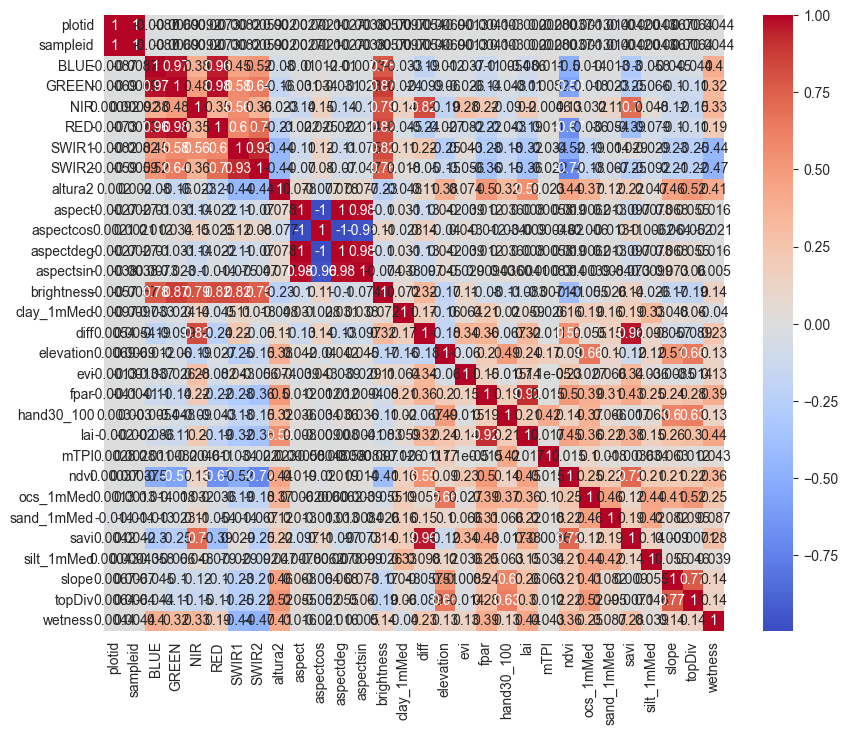

In [129]:
# Correlation Matrix, including with the different % cover values from the 1 point dataframe?
# TODO: Add correlation matrix for % cover values from the 1 point dataframe

predictors = gdf_predictors.select_dtypes(include=['float64', 'int64'])

correlation_matrix = predictors.corr()
#display(correlation_matrix)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.show()

In [130]:
display(gdf_predictors['Use'].unique())

array(['Forest', 'Grasslands', 'Wetlands', 'Other classes', 'Agriculture',
       'Forest plantation', 'No information', 'Not_Applicable'],
      dtype=object)

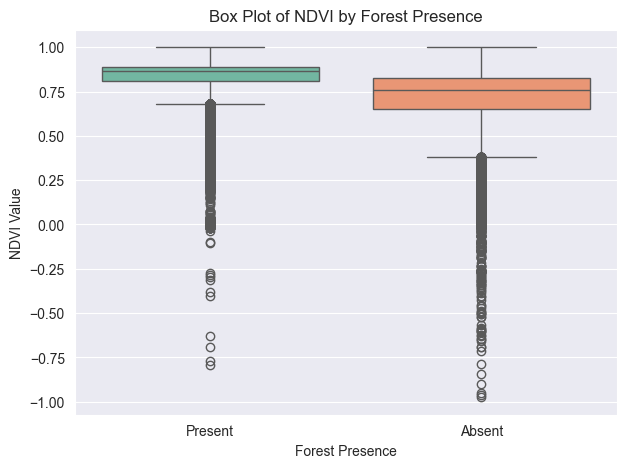

In [131]:
# Create a new column indicating 'Forest Present' or 'Absent'
gdf_predictors['Forest_Presence'] = gdf_predictors['Use'].apply(lambda x: 'Present' if x in ['Forest', 'Pasture ', 'Agriculture', 'Forest Plantation', 'WetLand'] else 'Absent')

# Create Boxplot with fixed palette assignment
plt.figure(figsize=(7, 5))
sns.boxplot(x='Forest_Presence', y='ndvi', data=gdf_predictors, hue='Forest_Presence', palette="Set2", legend=False)

# Labels and title
plt.xlabel("Forest Presence")
plt.ylabel("NDVI Value")
plt.title("Box Plot of NDVI by Forest Presence")

# Show plot
plt.show()

In [132]:
#We are checking all the values that have a absents in forest
absent_use_values = gdf_predictors[gdf_predictors['Forest_Presence'] == 'Absent']['Use']
print(absent_use_values)

1         Grasslands
2         Grasslands
9           Wetlands
12        Grasslands
13          Wetlands
             ...    
101124    Grasslands
101125    Grasslands
101127    Grasslands
101128    Grasslands
101130    Grasslands
Name: Use, Length: 34054, dtype: object


In [133]:
unique_absent_use_values = absent_use_values.unique()
print(unique_absent_use_values)
use_counts = absent_use_values.value_counts()
print(use_counts)

['Grasslands' 'Wetlands' 'Other classes' 'Forest plantation'
 'No information' 'Not_Applicable']
Use
Grasslands           23291
Other classes         5449
Wetlands              3926
Forest plantation      902
No information         270
Not_Applicable         216
Name: count, dtype: int64


In [134]:
high_ndvi_absent = gdf_predictors[(gdf_predictors['Forest_Presence'] == 'Absent') & (gdf_predictors['ndvi'] > 0.33)]

# Group by 'Vegetation' and calculate the mean NDVI
mean_ndvi_by_vegetation = high_ndvi_absent.groupby('Vegetations')['ndvi'].mean()
print(mean_ndvi_by_vegetation)


Vegetations
Herbaceous plants        0.738485
Not_Applicable           0.656464
Other vegetation         0.776051
Palms                    0.850959
Saran (plastic cover)    0.815512
Shrubs                   0.774400
Trees                    0.796539
Name: ndvi, dtype: float64


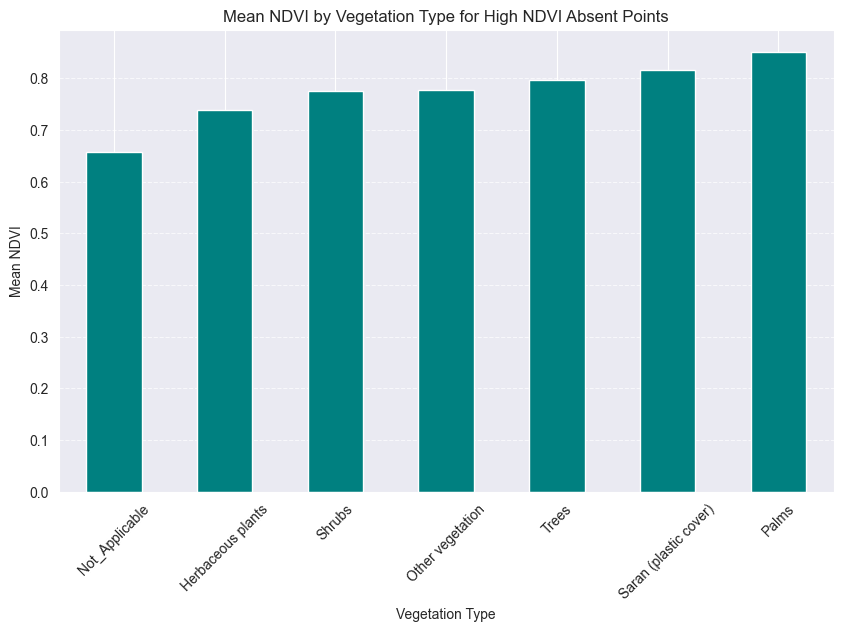

In [135]:
import matplotlib.pyplot as plt

# Filter and group by 'Vegetation', calculating the mean NDVI
high_ndvi_absent = gdf_predictors[(gdf_predictors['Forest_Presence'] == 'Absent') & (gdf_predictors['ndvi'] > 0.33)]
mean_ndvi_by_vegetation = high_ndvi_absent.groupby('Vegetations')['ndvi'].mean()

# Plot the results
plt.figure(figsize=(10, 6))
mean_ndvi_by_vegetation.sort_values().plot(kind='bar', color='teal')

# Customize the plot
plt.xlabel('Vegetation Type')
plt.ylabel('Mean NDVI')
plt.title('Mean NDVI by Vegetation Type for High NDVI Absent Points')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()


In [136]:
gdf_predictors.loc[(gdf_predictors['Forest_Presence'] == 'Absent') & (gdf_predictors['ndvi'] > 0.33), 'Forest_Presence'] = 'Present'


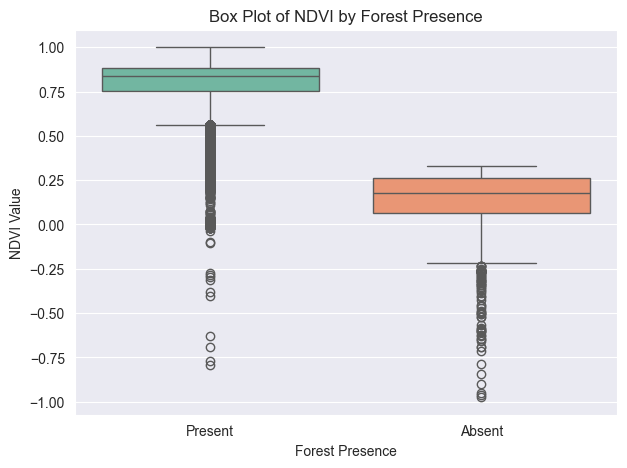

In [137]:
plt.figure(figsize=(7, 5))
sns.boxplot(x='Forest_Presence', y='ndvi', data=gdf_predictors, hue='Forest_Presence', palette="Set2", legend=False)

# Labels and title
plt.xlabel("Forest Presence")
plt.ylabel("NDVI Value")
plt.title("Box Plot of NDVI by Forest Presence")

# Show plot
plt.show()

In [138]:
q1 = gdf_predictors[gdf_predictors['Forest_Presence'] == 'Present']['ndvi'].quantile(0.25)
q3 = gdf_predictors[gdf_predictors['Forest_Presence'] == 'Present']['ndvi'].quantile(0.75)
iqr = q3 - q1
low_outlier_threshold = q1 - 1.5 * iqr

print(f"Low NDVI Outlier Threshold: {low_outlier_threshold}")


Low NDVI Outlier Threshold: 0.5625580430997668


In [139]:
low_ndvi_outliers = gdf_predictors[(gdf_predictors['Forest_Presence'] == 'Present') & (gdf_predictors['ndvi'] < low_outlier_threshold)]
low_ndvi_outliers


plotid  sampleid            Use      CoverType     Vegetations  \
18        2903     11609  Other classes  No vegetation  Not_Applicable   
19        2903     11610  Other classes  No vegetation  Not_Applicable   
63        2960     11837       Wetlands          Water  Not_Applicable   
66        2960     11840       Wetlands          Water  Not_Applicable   
67        2960     11841       Wetlands          Water  Not_Applicable   
...        ...       ...            ...            ...             ...   
101084  906847   3627390         Forest     Vegetation           Trees   
101085  906847   3627391         Forest     Vegetation           Trees   
101086  906847   3627392         Forest     Vegetation           Trees   
101087  906847   3627393         Forest     Vegetation           Trees   
101151  904894   3619573         Forest     Vegetation           Trees   

            Herbaceous  GrasslandShrub       CropsType     WetlandArea  \
18      Not_Applicable  Not_Applicable  Not_Applicable  Not_Applicable   
19      Not_Applicable  Not_Applicable  Not_Applicable  Not_Applicable   
63      Not_Applicable  Not_Applicable  Not_Applicable    Water bodies   
66      Not_Applicable  Not_Applicable  Not_Applicable    Water bodies   
67      Not_Applicable  Not_Applicable  Not_Applicable    Water bodies   
...                ...             ...             ...             ...   
101084  Not_Applicable  Not_Applicable  Not_Applicable  Not_Applicable   
101085  Not_Applicable  Not_Applicable  Not_Applicable  Not_Applicable   
101086  Not_Applicable  Not_Applicable  Not_Applicable  Not_Applicable   
101087  Not_Applicable  Not_Applicable  Not_Applicable  Not_Applicable   
101151  Not_Applicable  Not_Applicable  Not_Applicable  Not_Applicable   

              LandType  ...    mTPI      ndvi ocs_1mMed sand_1mMed      savi  \
18      Other surfaces  ...  8132.0  0.528579      63.0     336.45  0.295504   
19      Other surfaces  ...  8132.0  0.437536      63.0     336.45  0.152839   
63      Not_Applicable  ...  8127.0  0.503759      58.0     264.65  0.249684   
66      Not_Applicable  ...  8127.0  0.421427      58.0     264.65  0.172648   
67      Not_Applicable  ...  8127.0  0.451770      58.0     264.65  0.212015   
...                ...  ...     ...       ...       ...        ...       ...   
101084  Not_Applicable  ...  8157.0 -0.010946     132.0     321.90 -0.012102   
101085  Not_Applicable  ...  8232.0 -0.010758     132.0     323.55 -0.011875   
101086  Not_Applicable  ...  8232.0 -0.011036     132.0     321.90 -0.012187   
101087  Not_Applicable  ...  8157.0 -0.010568     132.0     321.90 -0.011680   
101151  Not_Applicable  ...  8137.0 -0.008563     126.0     296.95 -0.010184   

       silt_1mMed      slope       topDiv   wetness  Forest_Presence  
18         265.70   7.437723  1323.698838 -0.032052          Present  
19         265.70   2.645458  1323.698838 -0.016620          Present  
63         268.00   3.382467  1323.673565 -0.056526          Present  
66         268.00   0.000000  1323.673565 -0.026745          Present  
67         268.00   0.000000  1323.673565 -0.072998          Present  
...           ...        ...          ...       ...              ...  
101084     333.90  55.651031  1324.630000  0.455953          Present  
101085     324.50  37.565701  1324.630000  0.467968          Present  
101086     333.90  53.213791  1324.630000  0.462251          Present  
101087     333.90  49.832008  1324.630000  0.460804          Present  
101151     354.95  32.235409  1324.494757  0.537303          Present  

[6148 rows x 45 columns]

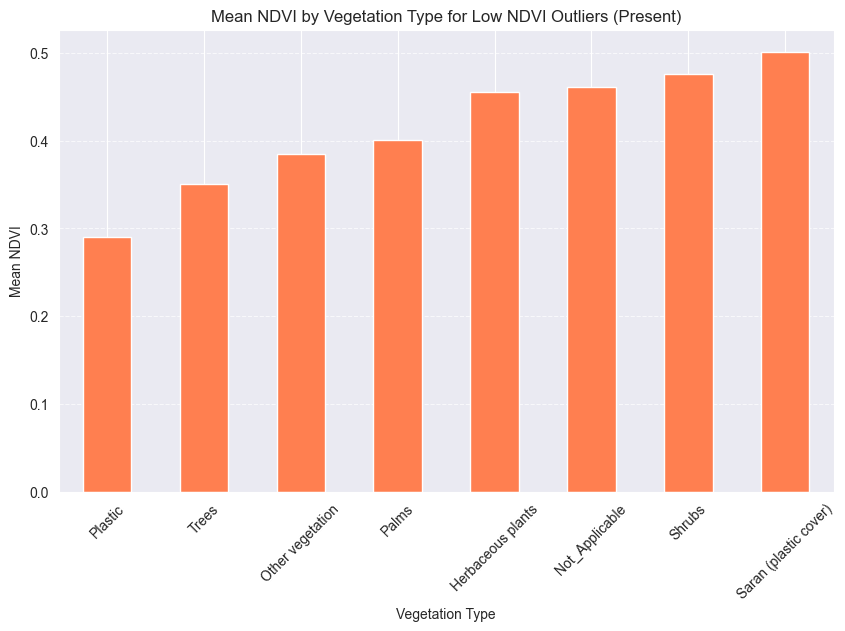

In [140]:
# Step 1: Calculate the IQR and identify low NDVI outliers for 'Present' Forest_Presence
q1 = gdf_predictors[gdf_predictors['Forest_Presence'] == 'Present']['ndvi'].quantile(0.25)
q3 = gdf_predictors[gdf_predictors['Forest_Presence'] == 'Present']['ndvi'].quantile(0.75)
iqr = q3 - q1
low_outlier_threshold = q1 - 1.5 * iqr

# Step 2: Filter the low NDVI outliers
low_ndvi_outliers = gdf_predictors[(gdf_predictors['Forest_Presence'] == 'Present') & (gdf_predictors['ndvi'] < low_outlier_threshold)]

# Step 3: Group by 'Vegetation' and calculate the mean NDVI
mean_ndvi_outliers_by_vegetation = low_ndvi_outliers.groupby('Vegetations')['ndvi'].mean()

# Step 4: Plot the results
plt.figure(figsize=(10, 6))
mean_ndvi_outliers_by_vegetation.sort_values().plot(kind='bar', color='coral')

# Customize the plot
plt.xlabel('Vegetation Type')
plt.ylabel('Mean NDVI')
plt.title('Mean NDVI by Vegetation Type for Low NDVI Outliers (Present)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()


In [141]:
low_ndvi_outliers.set_crs(epsg=4326, inplace=True)
# Save as Shapefile
low_ndvi_outliers.to_file('../Costa_Rica_Data/Data Acquisition Output/low_ndvi_outliers/low_ndvi_outliers.shp')

C:\Users\goldf\Documents\Programming\PycharmProjects\venv\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\goldf\AppData\Local\Temp\ipykernel_1812\2628181773.py:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  low_ndvi_outliers.to_file('../Costa_Rica_Data/Data Acquisition Output/low_ndvi_outliers/low_ndvi_outliers.shp')
C:\Users\goldf\Documents\Programming\PycharmProjects\venv\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'Vegetations' to 'Vegetation'
  ogr_write(
C:\Users\goldf\Documents\Programming\PycharmProjects\venv\Lib\site-packages\pyogrio\raw.py:723: Runtim

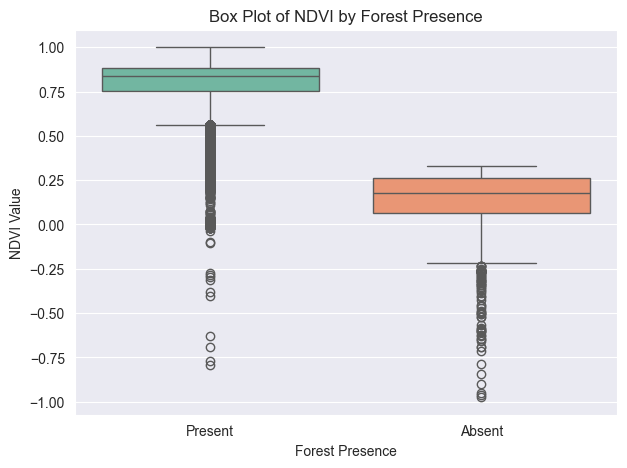

In [142]:
plt.figure(figsize=(7, 5))
sns.boxplot(x='Forest_Presence', y='ndvi', data=gdf_predictors, hue='Forest_Presence', palette="Set2", legend=False)

# Labels and title
plt.xlabel("Forest Presence")
plt.ylabel("NDVI Value")
plt.title("Box Plot of NDVI by Forest Presence")

# Show plot
plt.show()

In [143]:
len(low_ndvi_outliers)

6148

In [144]:
print(list(gdf_predictors.columns))

['plotid', 'sampleid', 'Use', 'CoverType', 'Vegetations', 'Herbaceous', 'GrasslandShrub', 'CropsType', 'WetlandArea', 'LandType', 'WaterBodyType', 'OtherClass', 'SAF', 'Changes_15', 'Gain_Loss', 'geometry', 'BLUE', 'GREEN', 'NIR', 'RED', 'SWIR1', 'SWIR2', 'altura2', 'aspect', 'aspectcos', 'aspectdeg', 'aspectsin', 'brightness', 'clay_1mMed', 'diff', 'elevation', 'evi', 'fpar', 'hand30_100', 'lai', 'mTPI', 'ndvi', 'ocs_1mMed', 'sand_1mMed', 'savi', 'silt_1mMed', 'slope', 'topDiv', 'wetness', 'Forest_Presence']


In [145]:
# Update the 'Forest_Presence' column for rows where 'Forest_Presence' is 'Present' and 'ndvi' <= -0.5
gdf_predictors.loc[(gdf_predictors['Forest_Presence'] == 1), 'Forest_Presence'] = 'Present'
gdf_predictors.loc[(gdf_predictors['Forest_Presence'] == 0), 'Forest_Presence'] = 'Absent'
gdf_predictors.head()

plotid  sampleid         Use   CoverType        Vegetations  \
0    2900     11597      Forest  Vegetation              Trees   
1    2900     11598  Grasslands  Vegetation  Herbaceous plants   
2    2900     11599  Grasslands  Vegetation  Herbaceous plants   
3    2900     11600      Forest  Vegetation              Trees   
4    2900     11601      Forest  Vegetation              Trees   

       Herbaceous          GrasslandShrub       CropsType     WetlandArea  \
0  Not_Applicable          Not_Applicable  Not_Applicable  Not_Applicable   
1         Grasses  Mixed Pasture (70-90%)  Not_Applicable  Not_Applicable   
2         Grasses  Mixed Pasture (70-90%)  Not_Applicable  Not_Applicable   
3  Not_Applicable          Not_Applicable  Not_Applicable  Not_Applicable   
4  Not_Applicable          Not_Applicable  Not_Applicable  Not_Applicable   

         LandType  ...    mTPI      ndvi ocs_1mMed sand_1mMed      savi  \
0  Not_Applicable  ...  8132.0  0.806129      69.0     352.00  0.537483   
1  Not_Applicable  ...  8132.0  0.778854      69.0     395.65  0.541566   
2  Not_Applicable  ...  8132.0  0.802353      69.0     395.65  0.413164   
3  Not_Applicable  ...  8132.0  0.837203      69.0     352.00  0.514825   
4  Not_Applicable  ...  8132.0  0.834810      69.0     395.65  0.492115   

  silt_1mMed     slope      topDiv   wetness  Forest_Presence  
0     274.05  4.994698  1323.71474 -0.032644          Present  
1     257.85  1.323483  1323.71474 -0.048439          Present  
2     257.85  2.645557  1323.71474 -0.009717          Present  
3     274.05  2.978611  1323.71474 -0.005730          Present  
4     257.85  5.060336  1323.71474 -0.006400          Present  

[5 rows x 45 columns]

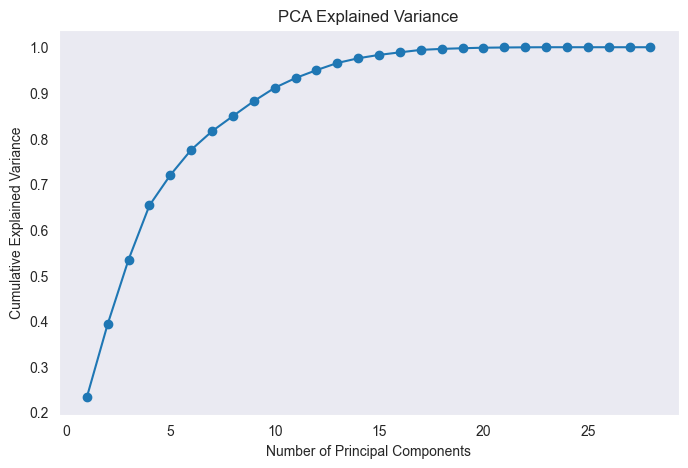

In [146]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Standardize the data
features = gdf_predictors.drop(['Forest_Presence', 'plotid', 'sampleid', 'Use', 'CoverType', 'Vegetations', 'Herbaceous', 'GrasslandShrub', 'CropsType', 'WetlandArea', 'LandType', 'WaterBodyType', 'OtherClass', 'SAF', 'Changes_15', 'Gain_Loss', 'geometry'], axis=1)  # Adjust columns as needed
features_scaled = StandardScaler().fit_transform(features)

# Apply PCA
pca = PCA()
principal_components = pca.fit_transform(features_scaled)

# Plot explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid()
plt.show()

In [147]:
# Retain the first 9 or 10 components
n_components = 10  # or 9, depending on how much variance you want to retain
reduced_data = principal_components[:, :n_components]

# Convert it back to a DataFrame for easier handling
reduced_df = pd.DataFrame(reduced_data, columns=[f'PC{i+1}' for i in range(n_components)])

# Add your target variable (Forest_Presence) back to the reduced dataset if needed
reduced_df['Forest_Presence'] = gdf_predictors['Forest_Presence'].values

# Show the first few rows of the reduced data
print(reduced_df.head())


        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  0.412925 -1.158896  1.524246 -2.846733 -0.218026  0.081854  0.149571   
1  1.448211  0.044829  0.313776 -2.005341 -0.575245  0.027663  0.153001   
2 -0.413746 -2.832611  0.521883 -1.605802  0.526603  1.404474  0.703888   
3 -0.472422 -1.173843  0.747075 -2.116158  0.575824  0.651342  0.387064   
4 -0.435539 -1.180218  0.187269 -1.473562  0.588339  0.808038  0.479813   

        PC8       PC9      PC10 Forest_Presence  
0 -0.638777 -0.110205 -0.074805         Present  
1 -1.232450 -0.316724 -0.133748         Present  
2 -0.636944 -0.442152 -0.041401         Present  
3 -0.344328 -0.251999 -0.088862         Present  
4 -0.634352 -0.585166 -0.170776         Present  


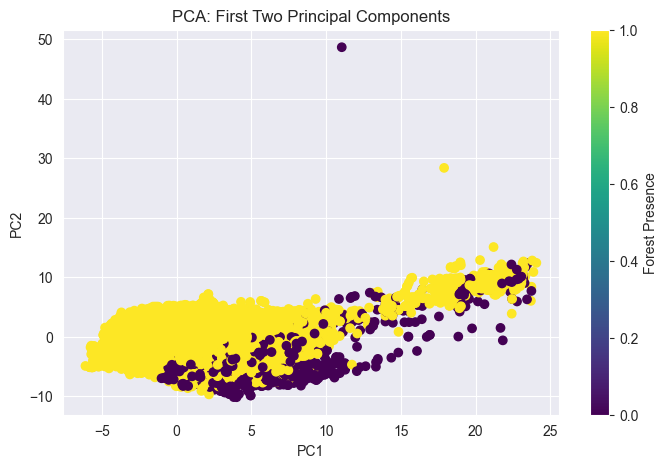

In [148]:
# Visualize the first two principal components
plt.figure(figsize=(8, 5))
plt.scatter(reduced_df['PC1'], reduced_df['PC2'], c=reduced_df['Forest_Presence'].map({'Present': 1, 'Absent': 0}), cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA: First Two Principal Components')
plt.colorbar(label='Forest Presence')
plt.show()


## Section 3 - Utilizing ML Models

In [149]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Split the data into features and target
X = reduced_df.drop('Forest_Presence', axis=1)
y = reduced_df['Forest_Presence']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

      Absent       0.93      0.76      0.84       245
     Present       1.00      1.00      1.00     19987

    accuracy                           1.00     20232
   macro avg       0.96      0.88      0.92     20232
weighted avg       1.00      1.00      1.00     20232



In [150]:
import pandas as pd

# Create a DataFrame with actual and predicted values
results_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred
}, index=y_test.index)

# Add a column to indicate whether the prediction was correct
results_df['Correct'] = results_df['Actual'] == results_df['Predicted']

# Subset the correct and incorrect predictions
correct_predictions = results_df[results_df['Correct'] == True]
incorrect_predictions = results_df[results_df['Correct'] == False]

# Print or save the new DataFrames
print("Correct Predictions:")
print(correct_predictions.head())

print("\nIncorrect Predictions:")
print(incorrect_predictions.head())


Correct Predictions:
        Actual Predicted  Correct
10538  Present   Present     True
89284  Present   Present     True
54303  Present   Present     True
11834  Present   Present     True
585    Present   Present     True

Incorrect Predictions:
        Actual Predicted  Correct
7696   Present    Absent    False
11535   Absent   Present    False
16231  Present    Absent    False
14762   Absent   Present    False
49189  Present    Absent    False


In [151]:
display(gdf_predictors['Vegetations'].unique())
#gdf_predictors = gdf_predictors[~gdf_predictors['Vegetation'].isin(['Not_Applicable'])]
display(gdf_predictors['Vegetations'].unique())

array(['Trees', 'Herbaceous plants', 'Not_Applicable', 'Palms', 'Shrubs',
       'Other vegetation', 'Saran (plastic cover)', 'Plastic'],
      dtype=object)

array(['Trees', 'Herbaceous plants', 'Not_Applicable', 'Palms', 'Shrubs',
       'Other vegetation', 'Saran (plastic cover)', 'Plastic'],
      dtype=object)

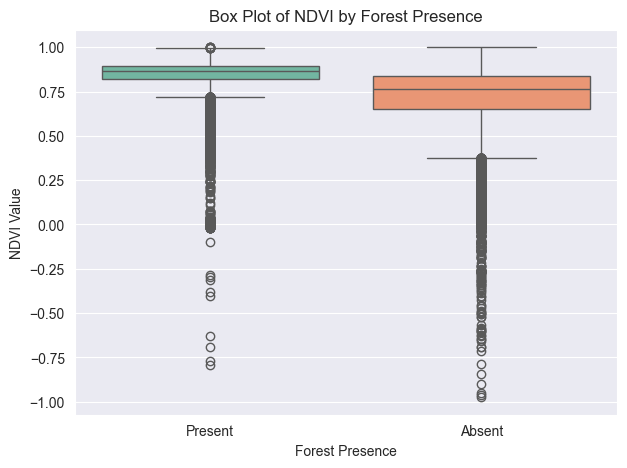

In [152]:
# Create a new column indicating 'Forest Present' or 'Absent'
gdf_predictors['Forest_Presence'] = gdf_predictors['Use'].apply(lambda x: 'Present' if x == 'Forest' else 'Absent')

# Create Boxplot with fixed palette assignment
plt.figure(figsize=(7, 5))
sns.boxplot(x='Forest_Presence', y='ndvi', data=gdf_predictors, hue='Forest_Presence', palette="Set2", legend=False)

# Labels and title
plt.xlabel("Forest Presence")
plt.ylabel("NDVI Value")
plt.title("Box Plot of NDVI by Forest Presence")

# Show plot
plt.show()

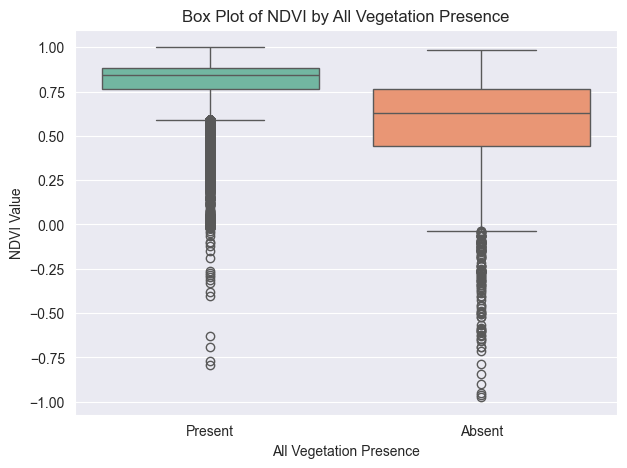

In [153]:
# Create a new column indicating 'Forest Present' or 'Absent'
gdf_predictors['Vegetation_Presence'] = gdf_predictors['Vegetations'].apply(lambda x: 'Present' if x in ['Trees', 'Herbaceous plants', 'Palms', 'Shrubs', 'Other vegetation', 'Saran (plastic cover)', 'Plastic'] else 'Absent')

# Create Boxplot with fixed palette assignment
plt.figure(figsize=(7, 5))
sns.boxplot(x='Vegetation_Presence', y='ndvi', data=gdf_predictors, hue='Vegetation_Presence', palette="Set2", legend=False)

# Labels and title
plt.xlabel("All Vegetation Presence")
plt.ylabel("NDVI Value")
plt.title("Box Plot of NDVI by All Vegetation Presence")

# Show plot
plt.show()